In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from abc import ABC, abstractmethod
from rl import get_bandit_envs, run_bandit
from rl import PosteriorHallucinationAlg, NeuralLinearAlg, BetaBernoulliAlg, UCBAlg
from run_bandit_psar import load_bandit_rewards, get_article_ordering
from train_fns import get_model_and_optimizer_MIND as get_model_and_optimizer

## Path Info

In [2]:
# needs to  match loaded
seed=23485223

# which data split to use
rl_dataset = 'val'

In [3]:
path_base = "/shared/share_mala/implicitbayes/dataset_files/MIND_data/filter100"

model_paths = {
    'BERT joint': '/shared/share_mala/implicitbayes/dataset_files/MIND_data/filter100/models/seq_bert_rerun/sequential:epochs=500,bs=100,lr=1e-05,wd=0.01,MLP_layers=3,MLP_width=100,weight_factor=1,max_obs=500,repeat_suffstat=100,bert_lr=1e-08,sample_frac=1.0,p_alpha=1,seed=2340923', 
    'category joint': '/shared/share_mala/implicitbayes/dataset_files/MIND_data/filter100/models/0404_MIND_category2/sequential:epochs=1000,bs=100,lr=0.001,wd=0.01,MLP_layers=3,MLP_width=50,weight_factor=1,max_obs=500,repeat_suffstat=10,category=1,sample_frac=1.0,p_alpha=1,sched=constant,seed=2340923'
}

# Load predictions, models, etc

In [4]:
# LOAD MODEL PREDICTIONS ===========================================
prediction_dicts = {}
for name, run_dir in model_paths.items():
    try:
        preds = torch.load(run_dir + '/best_loss_predictions.pt')
        prediction_dicts[name] = preds
    except:
        print(f'preds: skip {name}')
    
# LOAD MODEL CHECKPOINTS ===========================================
all_model_checkpoints = {}
for model_name, model_dir in model_paths.items():
    model_path = model_dir + "/best_loss.pt"
    model_dict = torch.load(model_path, map_location=torch.device('cpu'))
    all_model_checkpoints[model_name] = model_dict
    
# LOAD MODEL EMBEDDINGS ===========================================
model_embeds = {}
for model_name, model_dir in model_paths.items():
    try:
        model_path = model_dir + "/best_loss_row_embeds.pt"
        model_dict = torch.load(model_path, map_location=torch.device('cpu'))
        model_embeds[model_name] = model_dict
    except:
        print(f'embeds: skip {name}')

# Set up bandit env

In [5]:
val_batch_size = len(prediction_dicts['BERT joint'][rl_dataset]['click_rates'])
article_ordering = get_article_ordering(seed, val_batch_size)

In [6]:
# Get click rates for arms in val set ===============================================
success_p_all = None
for model_name, model_dict in all_model_checkpoints.items():
    if "marg" in model_name:
        continue

    # CHECK MATCH TO ENVIRONEMENT ARMS -------------------------------------
    model_saved_p_raw = model_dict[f'{rl_dataset}_loss_dict']['click_rates'].numpy()
    model_shuffled_p = model_saved_p_raw[article_ordering]
    
    if success_p_all is None:
        success_p_all = model_shuffled_p
    else:
        assert np.all( np.equal(success_p_all, model_shuffled_p) )

In [7]:
# Make bandit environments ------------------------------------
num_bandit_envs = 500
T = 1000
num_arms = 10
all_bandit_envs = get_bandit_envs(num_arms, T, num_bandit_envs, success_p_all, seed=seed, horizonDependent=True)
num_imagined = 500
bandit_run_results = {}

# Make bandit algs

**Oracle**

In [8]:
# REWARD UNDER ORACLE BANDIT ALGORITHM ========================================================
all_max_rewards = []
all_cum_rewards = []
for bandit_env, chosen_arms in all_bandit_envs:
    # This is different for horizon dependent algorithms
    mean_rewards = np.mean(bandit_env.potential_outcomes, axis=1)
    max_reward = np.max(mean_rewards)
    assert np.all( np.equal( bandit_env.success_p, success_p_all[chosen_arms] ) )
    all_max_rewards.append( np.ones(T)*max_reward )
    all_cum_rewards.append( np.cumsum( np.ones(T)*max_reward ) )
bandit_run_results['oracle'] = all_max_rewards

# Load bandit algs

**Sequential (text), fixed generation length**

In [10]:
num_imagined = 500
bandit_dir = model_paths['BERT joint'] + f'/bandit/num_arms={num_arms},T={T},num_imagined={num_imagined},seed={seed},dataset={rl_dataset},alg=sequential,horizonDep/'
bandit_rewards = load_bandit_rewards(bandit_dir, all_bandit_envs, success_p_all)
bandit_run_results[f'BERT joint im={num_imagined}'] = bandit_rewards['rewards']

**Sequential (text), full imputation**

In [11]:
bandit_dir = model_paths['BERT joint'] + f'/bandit/num_arms={num_arms},T={T},seed={seed},dataset={rl_dataset},alg=sequential_horizon,horizonDep/'
bandit_rewards = load_bandit_rewards(bandit_dir, all_bandit_envs, success_p_all)
bandit_run_results[f'BERT joint Horizon Dependent'] = bandit_rewards['rewards']

**Sequential (Category), fixed generation length**

In [12]:
num_imagined = 500
bandit_dir = model_paths['category joint'] + f'/bandit/num_arms={num_arms},T={T},num_imagined={num_imagined},seed={seed},dataset={rl_dataset},alg=sequential,horizonDep/'
bandit_rewards = load_bandit_rewards(bandit_dir, all_bandit_envs, success_p_all)
bandit_run_results[f'category joint im={num_imagined}'] = bandit_rewards['rewards']

**Sequential (Category), full imputation**

In [13]:
bandit_dir = model_paths['category joint'] + f'/bandit/num_arms={num_arms},T={T},seed={seed},dataset={rl_dataset},alg=sequential_horizon,horizonDep/'
bandit_rewards = load_bandit_rewards(bandit_dir, all_bandit_envs, success_p_all)
bandit_run_results[f'category joint Horizon Dependent'] = bandit_rewards['rewards']

**Greedy Predictive**

# Plot

In [16]:
import matplotlib.pyplot as plt

In [15]:
from util import make_plots_good
make_plots_good()

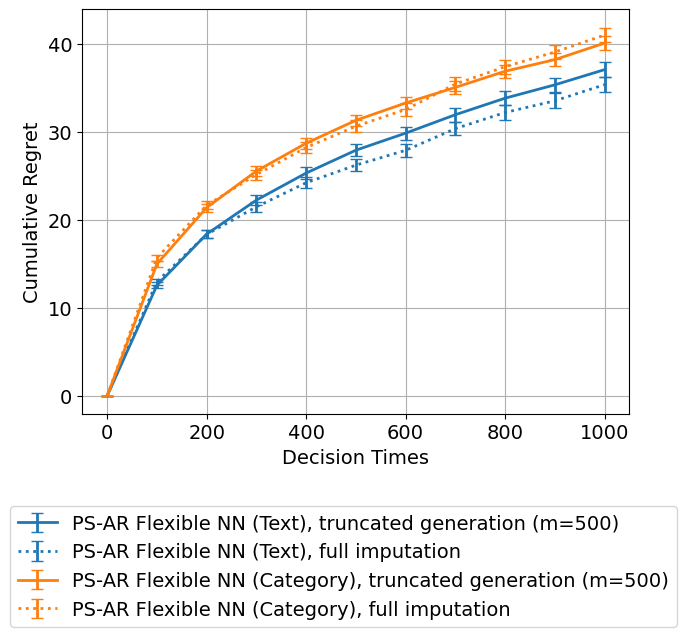

In [18]:
from collections import OrderedDict
names = OrderedDict([
    ('PS-AR Flexible NN (Text), truncated generation (m=500)','BERT joint im=500'),
    ('PS-AR Flexible NN (Text), full imputation','BERT joint Horizon Dependent'),
    ('PS-AR Flexible NN (Category), truncated generation (m=500)','category joint im=500'),
    ('PS-AR Flexible NN (Category), full imputation','category joint Horizon Dependent'),
])
skip_val = 100
linestyle = ['-', ':','-', ':']

plt.set_loglevel(level = 'warning')
fig, ax = plt.subplots(figsize=(6.5,5))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors = [colors[0],colors[0],colors[1],colors[1]]

k = 0
cutoff_num = 11
for disp_name, key in names.items():
    rewards_array = bandit_run_results[key]
    regret_array = bandit_run_results['oracle'] - rewards_array

    cum_regret_array = np.cumsum(regret_array, axis=1)
    cum_regret_array = np.hstack((np.zeros((len(cum_regret_array),1)), cum_regret_array))
    cum_regret = np.mean(cum_regret_array, axis=0)
    
    cum_regret_stderr = np.std(cum_regret_array, axis=0)  / np.sqrt(num_bandit_envs)

    ax.errorbar(x=np.arange(len(cum_regret))[::skip_val][:cutoff_num], y=cum_regret[::skip_val][:cutoff_num], 
                yerr=cum_regret_stderr[::skip_val][:cutoff_num], 
                capsize=4, linewidth=2, label=disp_name, 
                color=colors[k],
                linestyle=linestyle[k])
    ax.grid(True)
    k+=1
ax.set_ylabel("Cumulative Regret")
ax.set_xlabel("Decision Times")
plt.tight_layout()
plt.legend(loc='lower left', bbox_to_anchor=(-0.15,-0.55))
label_params = ax.get_legend_handles_labels() 